<a href="https://colab.research.google.com/github/grace-gg/neur-225/blob/main/03_27_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Examining Communication Between Two Different Continuously-Sampled Signals

We previously learned how to analyze and interpret data from one continuously-sampled signal (EEG or LFP). What happens when you have more than one signal? Different areas of the brain are anatomically-connected with one another - could you infer communication between these areas by looking at the EEG or LFP?

##By the end of this notebook, you will be able to:
- Visualize rhythmic activity between two signals
- Calculate the **phase coherence** between those signals
- Determine how phases might line up over time

##Background

In our last notebooks, we focused on field data recorded from a single electrode at the scalp (EEG) or in the brain (LFP). However, typical brain voltage recordings consist of multiple electrodes. For example, the standard EEG recording consists of [21 electrodes]('https://en.wikipedia.org/wiki/10%E2%80%9320_system_(EEG)') spaced across the scalp surface, and sometimes many more. The number of electrodes utilized in invasive ECoG (electrocorticography) recordings also range from a handful of contacts to over 100 implanted electrodes. In this module, we continue our study of field data recorded from the cortical surface but now consider ECoG data recorded simultaneously from two electrodes during a task.

##Case Study Data

We conside a patient with epilepsy admitted to the hospital for [resective surgery]('https://pubmed.ncbi.nlm.nih.gov/25602999/'). As part of her routine clinical workup before resective surgery, numerous electrodes were implanted [directly on the cortical surface]('https://en.wikipedia.org/wiki/Electrocorticography'). The purpose of this invasive recording procedure was to monitor and localize her seizures for eventual surgical treatment. During this recording procedure, in which electrocorticogram (ECoG) electrodes were implanted and recordings performed for one week, the patient volunteered to participate in an auditory task study administered by a collaborating researcher. The task required the patient to listen to individual phonemes through headphones and respond with a button click whenever she heard the [phoneme]('https://www.jneurosci.org/content/30/49/16643') “ba” (the other phonemes were different, e.g., “pa,” ”ma”). The tone presentation was repeated 100 times, and her ECoG recorded (sampling rate 500 Hz) from two cortical electrodes over the auditory brain area for 1 s.

In [1]:
# Loadin' modules

import numpy as np
import matplotlib.pyplot as plt


Visual inspection

We begin our analysis by visualizing the ECoG data. To do so, load the <code>ecoga.csv</code>, <code>ecogb.csv</code>, and <code>t.csv</code> files from our class GitHub repo in as <code>numpy</code> arrays named <code>ecoga</code>, <code>ecogb</code>, and <code>time</code>, respectively.

In [6]:
# Your code here
url1 = 'https://raw.githubusercontent.com/hallockh/neur_265/main/ecoga.csv'
ecoga = np.loadtxt(url1, delimiter = ',')

url2 = 'https://raw.githubusercontent.com/hallockh/neur_265/main/ecogb.csv'
ecogb = np.loadtxt(url2, delimiter = ',')

url3 = 'https://raw.githubusercontent.com/hallockh/neur_265/main/t.csv'
time = np.loadtxt(url3, delimiter = ',')

Our data are organized similarly to last week's data - specifically, rows correspond to trials, and columns correspond to samples. Look at the shape of your <code>ecoga</code> variable below to see how many trials there are:

In [7]:
# Your code here!
ecoga.shape

(100, 500)

><b>Task:</b> Let's go ahead and plot the first trial from <code>ecoga</code> in <font color = 'blue'>blue</font>, and the first trial from <code>ecogb</code> in <font color = 'red'>red</font>. Put time on the x-axis, and label your axes. What do you see? Does it look like the two signals have any kind of relationship?

Text(0.5, 0, 'time')

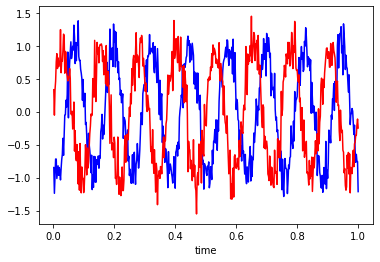

In [9]:
# Plot the raw data!
plt.plot(time, ecoga[0], color = "blue")
plt.plot(time, ecogb[0], color = "red")
plt.xlabel('time')

><b>Task:</b> Find the total length of the signal in seconds by indexing the last value of your <code>time</code> variable. Using this value, find the sampling rate of your data. 

In [13]:
# Find your sampling rate here
time[-1]

1.0

Question: What do you think the dominant oscillation in your two signals is? You can figure this out by counting the number of peaks in the signal, and dividing that number by the length of your signal (in seconds). 

there are 8 peaks over 1 second so the dominant oscillation is 8 Hz

These techniques allow us to visualize the data one trial at a time. Doing so is often useful but can be time consuming, especially as the number of trials increases. Here we have 100 trials, and to visualize all of them in this way would require 100 plots. That’s not so bad, but there’s a better way. We can display the entire structure of the data across both time and trials as an image:

Text(0.5, 1.0, 'All trials from ecoga')

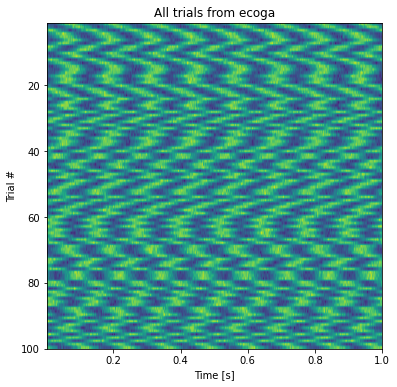

In [14]:
K = ecoga.shape[0]                            # Get the number of trials.
f, a = plt.subplots(figsize=(6, 6))            # Make a square axis
a.imshow(ecoga,                               #... and show the image,
           extent=[np.min(time), np.max(time), K, 1],  # ... with meaningful axes,
           aspect='auto')                  # ... and a nice aspect ratio.
plt.xlabel('Time [s]')
plt.ylabel('Trial #');
plt.title('All trials from ecoga')


The resulting image for the first electrode is shown in the figure above. Voltage (in color) is plotted as a function of time along the horizontal axis and trial number along the vertical axis. This allows us to visualize the voltage activity of the first electrode for all trials at once.

We notice that each trial exhibits rhythmic structure, which manifests in this image as repeating undulations of blue (low voltage), then green (high voltage) over time. We also observe variability in the alignment of these rhythms from trial to trial; from one trial to the next, the undulations appear not to align.

><b>Task:</b> Display an image of the activity for the second electrode and compare it to the image from the first electrode in the figure above. How do the two compare?

Text(0.5, 1.0, 'All trials from ecogb')

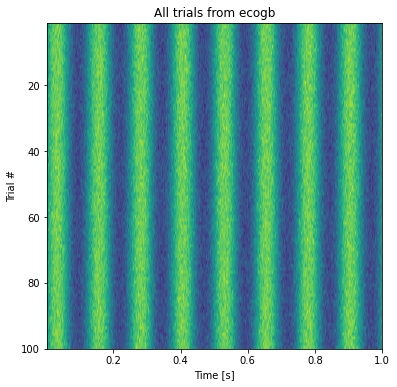

In [15]:
# Your code here!
K = ecogb.shape[0]                            # Get the number of trials.
f, a = plt.subplots(figsize=(6, 6))            # Make a square axis
a.imshow(ecogb,                               #... and show the image,
           extent=[np.min(time), np.max(time), K, 1],  # ... with meaningful axes,
           aspect='auto')                  # ... and a nice aspect ratio.
plt.xlabel('Time [s]')
plt.ylabel('Trial #');
plt.title('All trials from ecogb')


Visual inspection of the ECoG data allows us to draw some preliminary conclusions. First, the data appear to be rhythmic, with a particularly strong oscillation near 8 Hz. That’s interesting but not the primary research objective. We would really like to understand whether the activity at the two electrodes is related. Many techniques exist to approach this problem, but let’s begin with the most basic: visual inspection. Let’s examine the activity in the first four trials, and attempt to deduce whether a consistent relation exists between the two ECoG signals across trials.

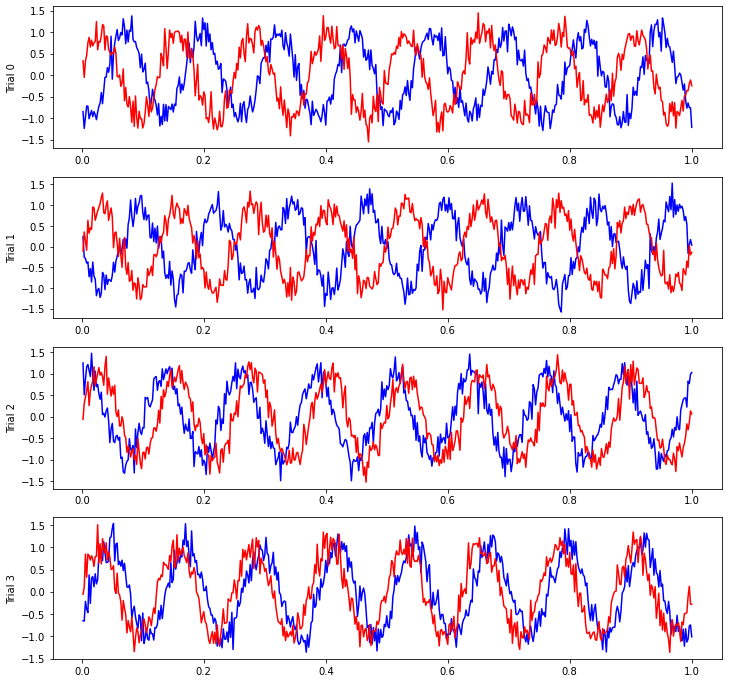

In [16]:
f, a = plt.subplots(4, 1, figsize=(12, 3*4))
for j in range(4):
    a[j].plot(time, ecoga[j], 'b')            # Plot the data from trial j of one electrode,
    a[j].plot(time, ecogb[j], 'r')            # ... and trial j of the other electrode.
    a[j].set_ylabel('Trial ' + str(j))
    

We notice in the first two trials that the ECoG activity from the two electrodes appears nearly out of phase (i.e., when the blue curve is near a peak, the red curve is near a trough). However, for the next two trials, activity from the two electrodes nearly overlaps. From this initial visual inspection of four trials, it’s difficult to conclude whether the ECoG activity at the two electrodes is interrelated; both electrodes display rhythmic activity across all trials, but the relation between these rhythms appears to change across trials: sometimes the activities overlap, and sometimes not.

><b>Task:</b> Plot trials 5-8 instead. Do this by modifying the loop above. Do you notice anything different about these trials?

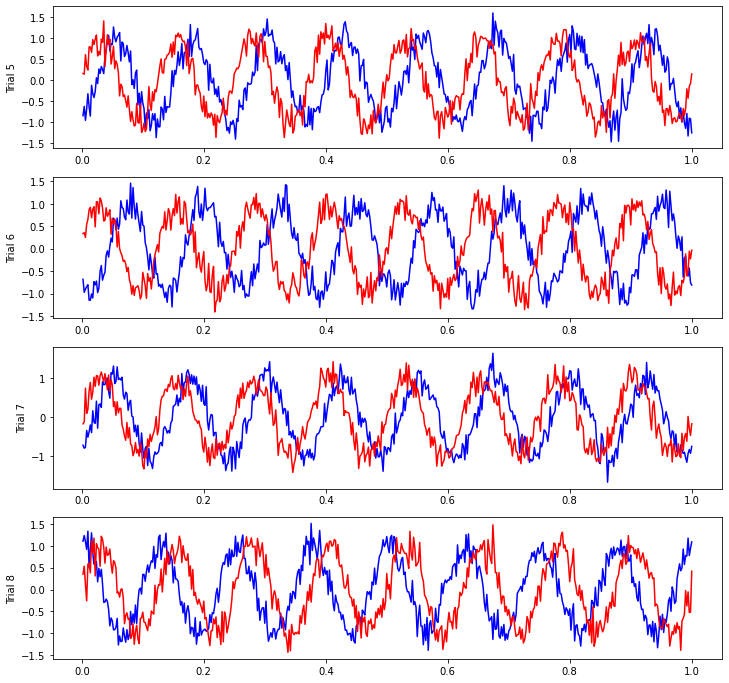

In [34]:
f, a = plt.subplots(4, 1, figsize=(12, 3*4))
for j in range(4):
    a[j].plot(time, ecoga[j+4], 'b')            # Plot the data from trial j of one electrode,
    a[j].plot(time, ecogb[j+4], 'r')            # ... and trial j of the other electrode.
    a[j].set_ylabel('Trial ' + str(j+5))

##Autocovariance and Cross-covariance

To see if rhythmic activity occurs at specific timepoints, we can apply something called **autocovariance** to our time series. The basic idea behind autocovariance is to take a signal and correlate it with itself at different **lags**. In other words - how well does a signal match up with itself at different points in time? 

Text(0.5, 1.0, 'Trial averaged autocovariance')

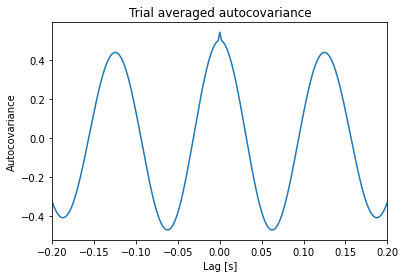

In [37]:
dt = time[1] - time[0]              # Define the sampling interval.
K = ecogb.shape[0]               # Define the number of trials.
N = ecogb.shape[1]               # Define number of points in each trial.
ac = np.zeros([2 * N - 1])       # Declare empty vector for autocov.

for trial in ecogb:              # For each trial,
    x = trial - trial.mean()  # ... subtract the mean,
    ac0 = 1 / N * np.correlate(x, x, 'full')  # ... compute autocovar,
    ac += ac0 / K;            # ... and add to total, scaled by 1/K.

lags = np.arange(-N + 1, N)      # Create a lag axis,
plt.plot(lags * dt, ac)           # ... and plot the result.
plt.xlim([-0.2, 0.2])
plt.xlabel('Lag [s]')
plt.ylabel('Autocovariance');
plt.title('Trial averaged autocovariance')


Question: What do these results suggest about the dominant rhythm in our data? Count the peaks that emerge from the autocovariance - which frequency is present?

><b>Task:</b> Repeat the autocovariance for <code>ecogb</code>. How do the results compare with the autocovariance from <code>ecoga</code>?

Taking this one step further - we're interested in looking at the covariance *between* the two electrodes. To do this, we can calculate something called the **cross-covariance**. The idea behind the cross-covariance is really similar to autocovariance - but instead of comparing a signal to itself, we'll compare one signal to a second signal at different lags.

Text(0.5, 1.0, 'Cross covariance between two electrodes during the first trial')

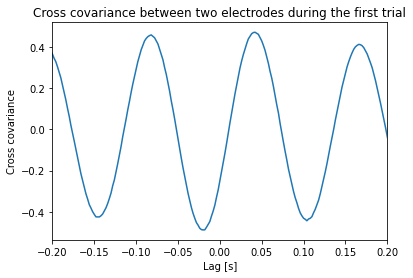

In [38]:
x = ecoga[0,:] - np.mean(ecoga[0,:])  # Define one time series,
y = ecogb[0,:] - np.mean(ecogb[0,:])  # ... and another.
xc=1/N*np.correlate(x,y,2)      # ... and compute their cross covariance.
lags = np.arange(-N+1,N)        # Create a lag axis,
plt.plot(lags*dt,xc)             # ... and plot the cross covariance vs lags in time.

plt.xlim([-0.2, 0.2])            # In a nice range, with axes labelled.
plt.xlabel('Lag [s]')
plt.ylabel('Cross covariance');
plt.title('Cross covariance between two electrodes during the first trial')


Question: Examine the cross-covariance between the ECoG data from the two electrodes in the first trial. What do you observe? At what lags are the largest and smallest values of the cross-covariance? How do these results compare to the trial-averaged autocovariance? How do these results compare to the voltage traces from each electrode in the first trial?

><b>Task:</b> Repeat the steps above for trials 2, 3, and 4. Does the dominant oscillation change? How about the relationship between the two oscillations?

Text(0.5, 1.0, 'Cross covariance between two electrodes during the first trial')

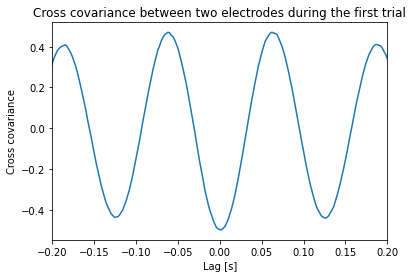

In [39]:
x = ecoga[1,:] - np.mean(ecoga[1,:])  # Define one time series,
y = ecogb[1,:] - np.mean(ecogb[1,:])  # ... and another.
xc=1/N*np.correlate(x,y,2)      # ... and compute their cross covariance.
lags = np.arange(-N+1,N)        # Create a lag axis,
plt.plot(lags*dt,xc)             # ... and plot the cross covariance vs lags in time.

plt.xlim([-0.2, 0.2])            # In a nice range, with axes labelled.
plt.xlabel('Lag [s]')
plt.ylabel('Cross covariance');
plt.title('Cross covariance between two electrodes during the second trial')

Text(0.5, 1.0, 'Cross covariance between two electrodes during the second trial')

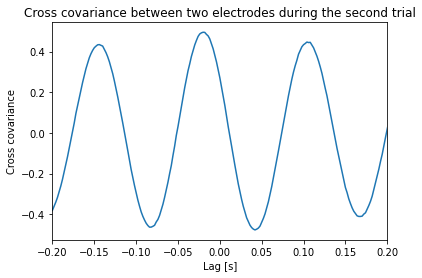

In [40]:
x = ecoga[2,:] - np.mean(ecoga[2,:])  # Define one time series,
y = ecogb[2,:] - np.mean(ecogb[2,:])  # ... and another.
xc=1/N*np.correlate(x,y,2)      # ... and compute their cross covariance.
lags = np.arange(-N+1,N)        # Create a lag axis,
plt.plot(lags*dt,xc)             # ... and plot the cross covariance vs lags in time.

plt.xlim([-0.2, 0.2])            # In a nice range, with axes labelled.
plt.xlabel('Lag [s]')
plt.ylabel('Cross covariance');
plt.title('Cross covariance between two electrodes during the third trial')

Text(0.5, 1.0, 'Cross covariance between two electrodes during the fourth trial')

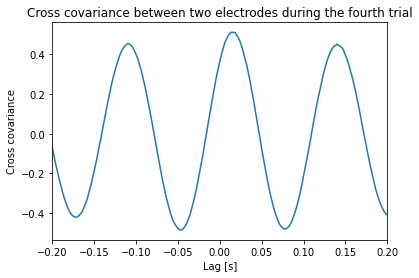

In [41]:
x = ecoga[3,:] - np.mean(ecoga[3,:])  # Define one time series,
y = ecogb[3,:] - np.mean(ecogb[3,:])  # ... and another.
xc=1/N*np.correlate(x,y,2)      # ... and compute their cross covariance.
lags = np.arange(-N+1,N)        # Create a lag axis,
plt.plot(lags*dt,xc)             # ... and plot the cross covariance vs lags in time.

plt.xlim([-0.2, 0.2])            # In a nice range, with axes labelled.
plt.xlabel('Lag [s]')
plt.ylabel('Cross covariance');
plt.title('Cross covariance between two electrodes during the fourth trial')

We've computed the cross-covariance for one trial, but we're interested in knowing whether the relationship between the two signals is consistent from trial to trial. To determine whether this is the case, we can compute the averaged cross-covariance instead. Below, let's do this for the first four trials:

Text(0.5, 1.0, 'Single-trial cross-covariance')

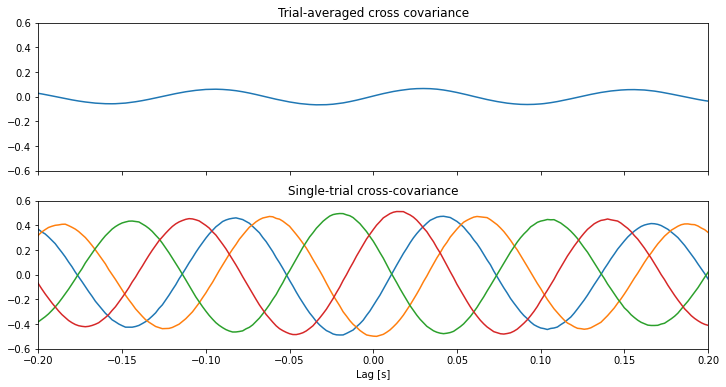

In [42]:
XC = np.zeros([K, 2 * N - 1])    # Declare empty vector for cross cov.
for k in range(K):            # For each trial,
    x = ecoga[k] - ecoga[k].mean()  # ...get data from one electrode,
    y = ecogb[k] - ecogb[k].mean()  # ...and the other electrode,
    XC[k] = 1 / N * np.correlate(x, y, 'full')  # ...compute cross covariance.

f, (a1, a2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)    
a1.plot(lags * dt, XC.mean(0))                 # Plot cross covariance vs lags in time.
[a2.plot(lags * dt, XC[k]) for k in range(4)]  # Also, plot the single-trial cross-covariance for 4 trials

plt.xlim([-0.2, 0.2])             # In a nice range, with axes labelled.
plt.ylim([-0.6, 0.6])
plt.xlabel('Lag [s]')
a1.set_title('Trial-averaged cross covariance')
a2.set_title('Single-trial cross-covariance')


Question: What differences and similarities do you observe between the single-trial cross-covariances? Does the trial-averaged cross-covariance make sense? What does this say about the relationships between the two signals?

##Introduction to the Coherence

Coherence is a measure of association between two time series. Briefly:

Two signals are coherent at some frequency if there exists a constant phase relation between them at this frequency. To illustrate this, let's look at a couple of examples:

##Simple Scenario 1: Phases align across trials

First, we assume that at a specific frequency index 𝑗
, the two signals possess a constant phase difference across trials. Under this assumption, the phase difference in the first trial (Φ𝑗,1
) equals the phase difference in the second trial (Φ𝑗,2
), which equals the phase difference in the third trial (Φ𝑗,3
), and so on for all trials. To denote this equivalence in the phase difference across trials, let’s replace the symbol for the phase difference Φ𝑗,𝑘
 with Φ𝑗,0
; here, we have replaced the subscript 𝑘
 with the subscript 0
 to remind ourselves that the phase difference does not depend upon the choice of trial. Now consider the expression:

 exp(𝑖Φ𝑗,0).

 This term defines a point in the complex plane with amplitude 1, which we can visualize as a vector leaving the origin at angle Φ𝑗,0
 to the real axis. Consider, for example, the leftmost plot in the figure below:

<img src = 'https://drive.google.com/uc?id=1WSjmbHrmDZBcmsuaAG4-oqWh2kdQ61F3'>

In this cartoon illustration of the complex plane, we plot the phase difference for each trial (orange arrow). In this case, the phase difference is the same across all trials.

The summation of these terms across trials then becomes,

∑𝑘=1𝐾exp(𝑖Φ𝑗,0).

This expression defines a sum of vectors in the complex plane, each of radius 1 (indicated by the blue circle in the figure). Because the phase difference is the same for each trial, these vectors point in the same direction for each trial. Then by summing up these vectors end to end across trials, we produce a long vector in the complex plane that terminates far from the origin, as shown in the righmost panel of the figure above.

The coherence is this vector length, divided by 𝐾
, so we conclude in this case that,

𝜅𝑥𝑦,𝑗=1,

which indicates strong coherence between the two signals. The strong coherence in this case results from the constant phase relationship between the two signals across trials at frequency index 𝑗
.

##Simple Scenario 2: Phases are random across trials

As a second scenario, consider another specific frequency 𝑗
 in which the two signals have a random phase difference in each trial. In this case, the phase difference can assume any value between 0
 and 2𝜋
 for each trial. To visualize this, let’s imagine the phase differences in the complex plane; in this scenario, the vectors point in different (random) directions from trial to trial:

<img src = 'https://drive.google.com/uc?id=1EMkO-iyNGkEP3eC4NZJZXcSs6HEbCxdM'>

Question: Consider the sum of these vectors end to end in the complex plane, plotted in the rightmost panel of the figure above. What is the approximate length of this summed vector across trials?

Under the simplifying assumption that the amplitude is identical at this frequency for both signals and all trials, the coherenceeq is this summed vector length, divided by 𝐾
. Our visual inspection of the cartoon in the figure above (rightmost panel) suggests that this summed vector length will be small. Therefore, for this scenario we conclude that,

𝜅𝑥𝑦,𝑗≈0,

which indicates weak coherence between the two signals. The weak coherence in this case results from the random phase relationship over trials between the two signals.

These two examples illustrate in simplified scenarios the behavior of the coherence. To summarize, the coherence is a measure of the relationship between 𝑥
 and 𝑦
 at the same frequency. The coherence ranges between 0 and 1,

0≤𝜅𝑥𝑦,𝑗≤1,

in which:

0
 indicates no coherence between signals 𝑥
 and 𝑦
 at frequency index 𝑗
, and

1 indicates strong strong coherence between signals 𝑥
 and 𝑦
 at frequency index 𝑗
.

##Computing the Coherence

With that introduction, we are now equipped to compute the coherence. We expect the coherence to reveal the frequencies at which the two ECoG signals exhibit a constant phase relation across trials.

Question: Before we compute the coherence, hypothesize whether you expect to observe coherence between the two ECoG signals. If so, at what frequencies? 

There are a variety of alternatives to compute the coherence. To start, let’s compute the coherence by hand. The reason for doing so is that we can implement the preceding mathematical expressions and in that way gain more understanding of their features. Here’s the Python code:

Text(0.5, 1.0, 'Coherence between two electrodes')

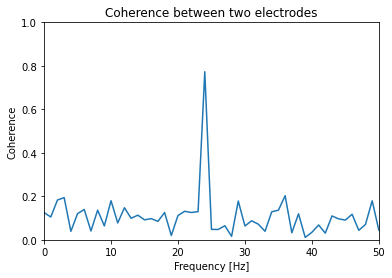

In [43]:
# Compute the Fourier transforms
xf = np.array([np.fft.rfft(x - x.mean()) for x in ecoga])  # ... for each trial in E1
yf = np.array([np.fft.rfft(y - y.mean()) for y in ecogb])  # ... and each trial in E2

# Compute the spectra
T = time[-1]
scale = 2 * dt**2 / T
Sxx = scale * (xf * xf.conj()).mean(0)  # Spectrum of E1 trials
Syy = scale * (yf * yf.conj()).mean(0)  # ... and E2 trials
Sxy = scale * (xf * yf.conj()).mean(0)  # ... and the cross spectrum

# Compute the coherence.
cohr = np.abs(Sxy) / (np.sqrt(Sxx) * np.sqrt(Syy))

f = np.fft.rfftfreq(N, dt)                     # Define a frequency axis.
plt.plot(f, cohr.real)                      # Plot coherence vs frequency,
plt.xlim([0, 50])                           # ... in a chosen frequency range,
plt.ylim([0, 1])                            # ... with y-axis scaled,
plt.xlabel('Frequency [Hz]')                # ... and with axes labeled.
plt.ylabel('Coherence')
plt.title('Coherence between two electrodes')


Question: Consider the coherence between the two ECoG electrodes plotted in the figure above. At what frequencies do strong coherences appear? How do these frequencies compare to the trial-averaged cross-covariance?

##Visualizing the Phase Difference across Trials

The coherence results suggest for the two ECoG recordings a constant phase relation across trials at 24 Hz and a random phase relation across trials at 8 Hz. To further explore these relations, let’s visualize the distribution of phase differences at the two frequencies, as implemented in the following Python code:

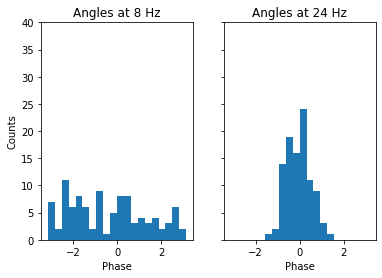

In [44]:
j8 = np.where(f==8)[0][0]       # Determine index j for frequency 8 Hz.
j24 = np.where(f==24)[0][0]     # Determine index j for frequency 24 Hz.

phi8 = np.zeros(K)              # Variables to hold phase differences.
phi24 = np.zeros(K)

for k in range(K):           # For each trial, compute the cross spectrum. 
    x = ecoga[k] - np.mean(ecoga[k])  # Get the data from each electrode,
    y = ecogb[k] - np.mean(ecogb[k,:])
    xf = np.fft.rfft(x - np.mean(x))   # ... compute the Fourier transform,
    yf = np.fft.rfft(y - np.mean(y))
    Sxy = 2 * dt**2 / T * (xf * np.conj(yf))  # ... and the cross-spectrum,
    phi8[k] = np.angle(Sxy[j8]) # ... and the phases.
    phi24[k] = np.angle(Sxy[j24])
                             # Plot the distributions of phases.
_, (a1, a2) = plt.subplots(1, 2, sharey=True, sharex=True)
a1.hist(phi8, bins=20, range=[-np.pi, np.pi])
a2.hist(phi24, bins=20, range=[-np.pi, np.pi])

plt.ylim([0, 40])                # Set y-axis and label axes.
a1.set_ylabel('Counts')
a1.set_xlabel('Phase');
a1.set_title('Angles at 8 Hz')

a2.set_title('Angles at 24 Hz')
a2.set_xlabel('Phase');

Again, we’re encountering quite a bit of Python code. Fortunately, large chunks of this code are familiar. We reuse useful quantities, like the number of trials (K) and the frequency axis (f). Then, within the frequency axis variable (f), we use the function where to identify the indices corresponding to a frequency of 8 Hz and a frequency of 24 Hz. For each trial, we then compute the cross-spectrum (Sxy). The cross-spectrum is a complex quantity at each frequency, and we identify the angle in the complex plane corresponding to the frequencies 8 Hz and 24 Hz using the Python function `angle`. We store these results in two vectors, `phi8` and `phi24`.

To summarize the results, we plot a histogram of the phase differences. We divide the phase axis into 20 bins of equal size from 0 to 2$\pi$ radians, or equivalently, 0 to 360 degrees. At 8 Hz, we observe that phase differences appear in all angular intervals; notice that the number of phase differences located in each angular interval remains small, typically less than 10. At 24 Hz, the angular differences concentrate near 0 degrees; all of the angles lie between approximately 60 and 60 degrees. This visualization is consistent with the strong coherence at 24 Hz, indicative of a consistent phase difference across trials between the two electrodes.





><b>Task:</b> Compute and display the distribution of phase differences at other frequencies - try 20 Hz, 30 Hz, and 40 Hz. What do you find? Are these results consistent with the coherence?

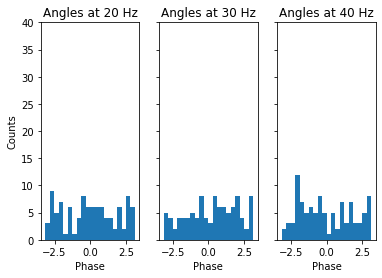

In [47]:
j20 = np.where(f==20)[0][0]       # Determine index j for frequency 8 Hz.
j30 = np.where(f==30)[0][0]     # Determine index j for frequency 24 Hz.
j40 = np.where(f==40)[0][0]

phi20 = np.zeros(K)              # Variables to hold phase differences.
phi30 = np.zeros(K)
phi40 = np.zeros(K)

for k in range(K):           # For each trial, compute the cross spectrum. 
    x = ecoga[k] - np.mean(ecoga[k])  # Get the data from each electrode,
    y = ecogb[k] - np.mean(ecogb[k,:])
    xf = np.fft.rfft(x - np.mean(x))   # ... compute the Fourier transform,
    yf = np.fft.rfft(y - np.mean(y))
    Sxy = 3 * dt**3 / T * (xf * np.conj(yf))  # ... and the cross-spectrum,
    phi20[k] = np.angle(Sxy[j20]) # ... and the phases.
    phi30[k] = np.angle(Sxy[j30])
    phi40[k] = np.angle(Sxy[j40])

                             # Plot the distributions of phases.
_, (a1, a2, a3) = plt.subplots(1, 3, sharey=True, sharex=True)
a1.hist(phi20, bins=20, range=[-np.pi, np.pi])
a2.hist(phi30, bins=20, range=[-np.pi, np.pi])
a3.hist(phi40, bins=20, range=[-np.pi, np.pi])

plt.ylim([0, 40])                # Set y-axis and label axes.
a1.set_ylabel('Counts')
a1.set_xlabel('Phase');
a1.set_title('Angles at 20 Hz')

a2.set_title('Angles at 30 Hz')
a2.set_xlabel('Phase');

a3.set_title('Angles at 40 Hz')
a3.set_xlabel('Phase');